In [1]:
# import numpy as np
# import nibabel as nib
# import matplotlib.pyplot as plt
# import os 
# opj = os.path.join


%load_ext autoreload
%autoreload 2
import scipy.io
import numpy as np  
import scipy.io
import matplotlib.pyplot as plt
import os
import linescanning.utils as lsutils
import linescanning.plotting as lsplt
opj = os.path.join

from amb_scripts.load_saved_info import *
from amb_scripts.plot_functions import *
# from amb_scripts.plot_shifts import *

# from prfpy.rf import csf_exponential
from amb_scripts.plot_csf import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


ModuleNotFoundError: No module named 'amb_scripts.pyctx'

In [4]:
# prf_obj 
# prf_obj = Prf1T1M('sub-01', 'LE', 'norm')

In [9]:
a = prf_obj.return_vx_mask(th={'min-rsq':.1})

min-rsq


In [9]:
# Load the dm stuff
from amb_scripts.load_saved_info import *
csf_dm = amb_load_dm(['sf_vect', 'c_vect'])
sf_vect = csf_dm['sf_vect']
c_vect = csf_dm['c_vect']
csf_seq = np.squeeze(scipy.io.loadmat('./csf_image_seq.mat')['csf_image_seq']) - 1 # -1 because matlab numbering
csf_seqtiming = np.squeeze(scipy.io.loadmat('./csf_seqtiming.mat')['stim_seqtiming']) 
csf_images = scipy.io.loadmat('./csf_images270.mat')['csf_images']

In [12]:
roi_fit = 'all'
fit_stage = 'iter'
G_plot = {}
G_plot['sub-01'] = AmbPlotter('sub-01', roi_fit=roi_fit, fit_stage=fit_stage)
G_plot['sub-02'] = AmbPlotter('sub-02', roi_fit=roi_fit, fit_stage=fit_stage)

FileNotFoundError: Could not find file with incl ['sub-01', 'norm', 'pRFLE', 'all', 'iter'], excluding: ['avg_bold', '.txt'], in /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/prf/sub-01/ses-1

In [ ]:
# SOMETHING TO SET IT UP NICE? LINESCANNING LAZYPLOT..
# sub = 'sub-02'
# idx = 0
# fig = plt.figure(constrained_layout=True, figsize=(15,5))
# ax = fig.add_subplot()
# lsplt.LazyPlot(
#     G_plot[sub].real_tc['CSF']['LE'][idx,0:50],
#     color='k', 
#     labels='CSF-LE', 
#     add_hline='default',
#     x_label='time',
#     axs=ax,
    
#     # title=set_title,
#     # xkcd=True,
#     # font_size=font_size,
#     # line_width=LP_lw,
#     # markers=LP_marker,
#     # **kwargs,
#     )


# MODEL EXPLANATION

In [ ]:
# Start simple -> The gratings + the 

# TIME SERIES 

In [375]:
sub='sub-02'
eye = 'LE'
idx = np.where(G_plot['sub-02'].return_vx_mask({
    'CSF-LE-min-rsq':.4,
    'CSF-LE-bound-bold_baseline':[-.5,.5]}))[0][1]


save_name = f'./csf_tc_{sub}-{eye}-vx{idx}'
if not os.path.exists(save_name):
    os.mkdir(save_name)
i_0 = 0
i_m1 = 214
i_step = 1
i_fig = 0
for i in range(i_0,i_m1,i_step):
    fig = G_plot[sub].csf_tc_plotV3(eye, idx, i)

    fig.savefig(f"{save_name}/file{i_fig:03}.png")
    plt.close(fig)
    print(i_fig)
    i_fig += 1

# ffmpeg_dir = "/home/**your_name**/.conda/envs/**env_name**/bin/ffmpeg"
ffmpeg_dir = '~/.conda/envs/dnsim_as/bin/ffmpeg'
# Select the directory with all of the images, and file name pattern
# >> -r 15 controls frame rate, can be faster or slower 
os.system(f"{ffmpeg_dir} -r 5 -i {save_name}/file%03d.png -codec mpeg4 -y {save_name}_movie.mp4")
os.system(f"rm -R {save_name}")
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/daghlian/.conda/envs/dnsim_as --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.

0

0
1
2
3
4
5
6
7
8
9
10
11
12
13


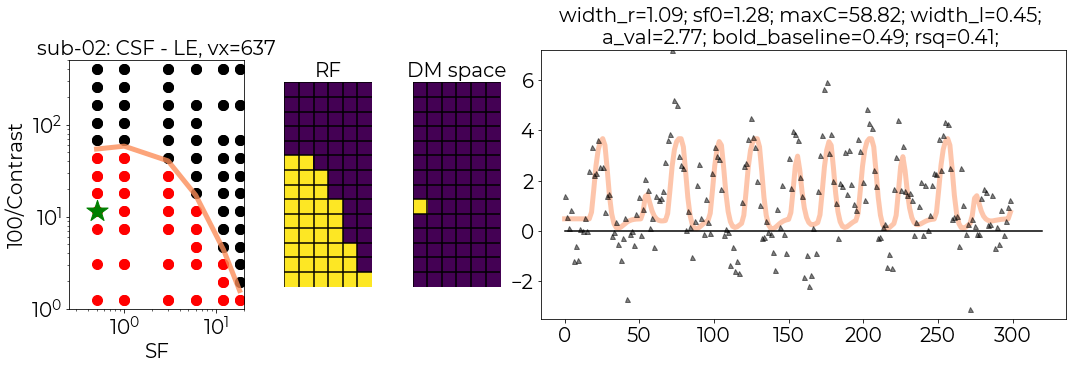

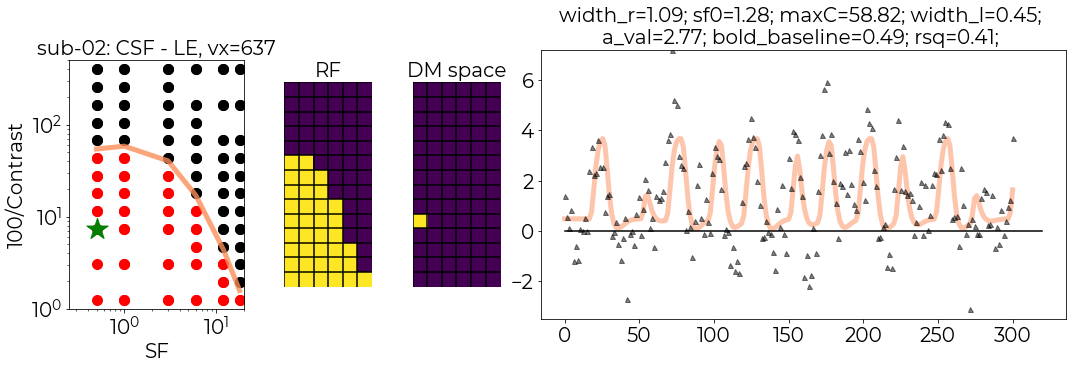

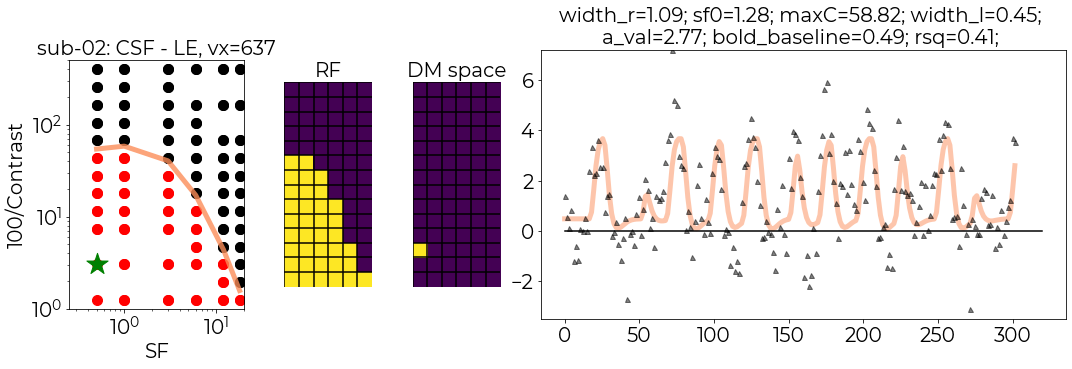

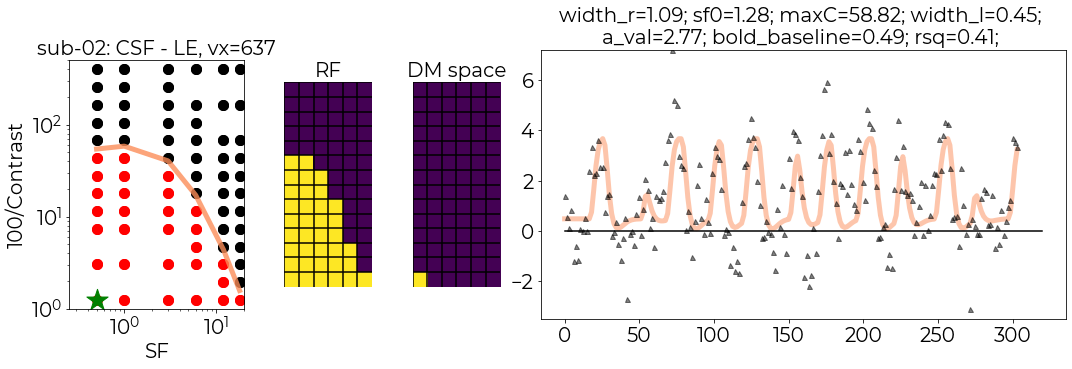

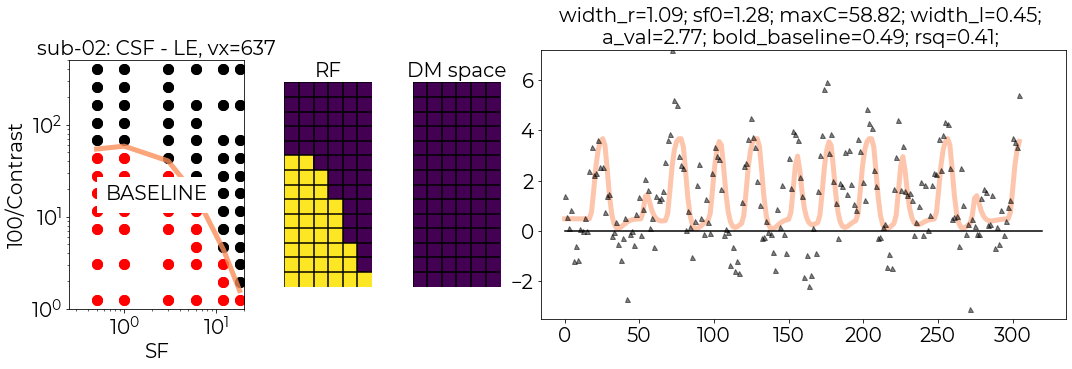

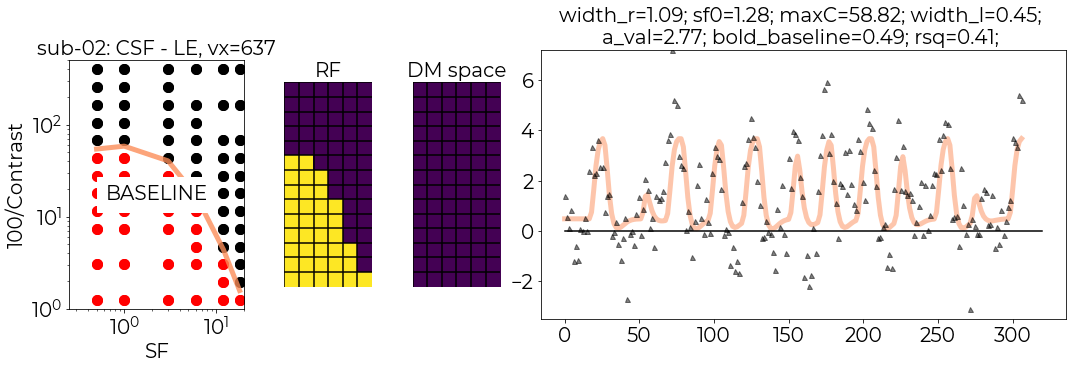

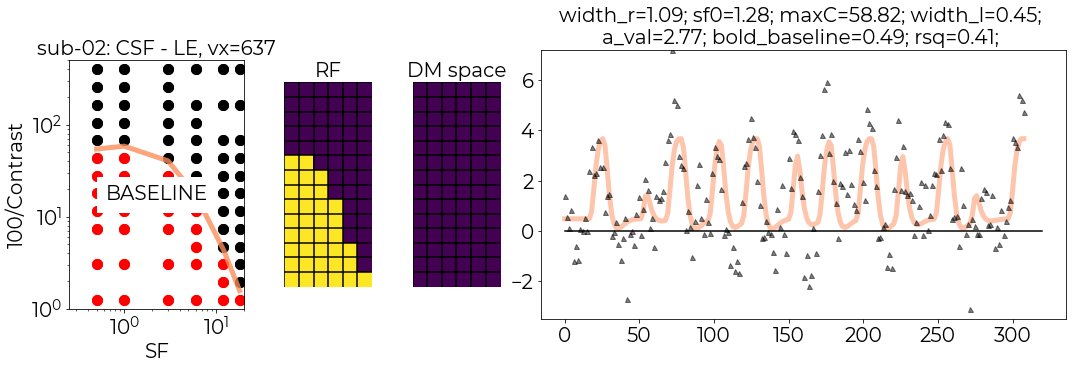

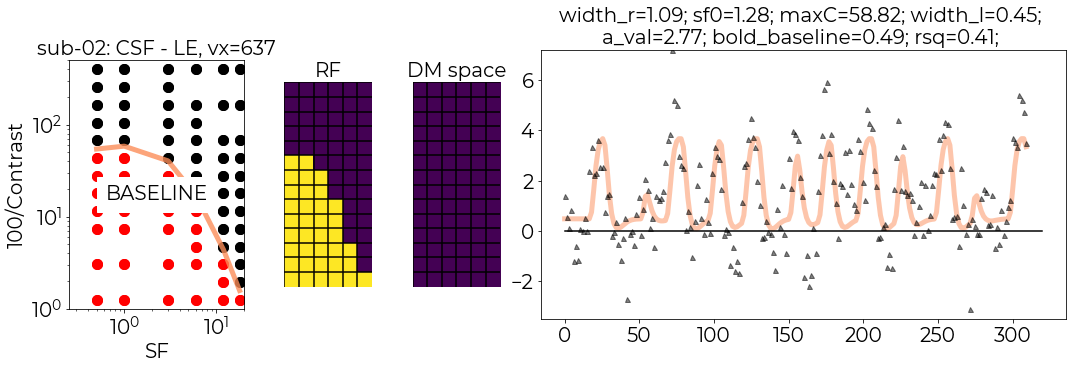

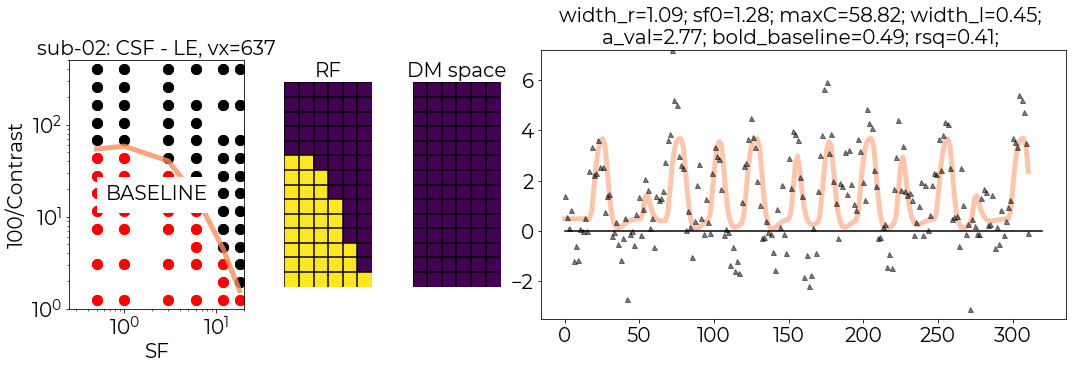

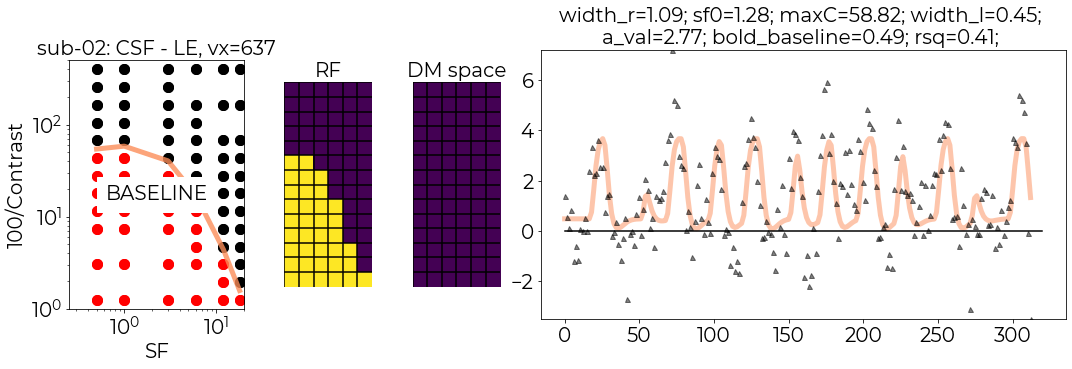

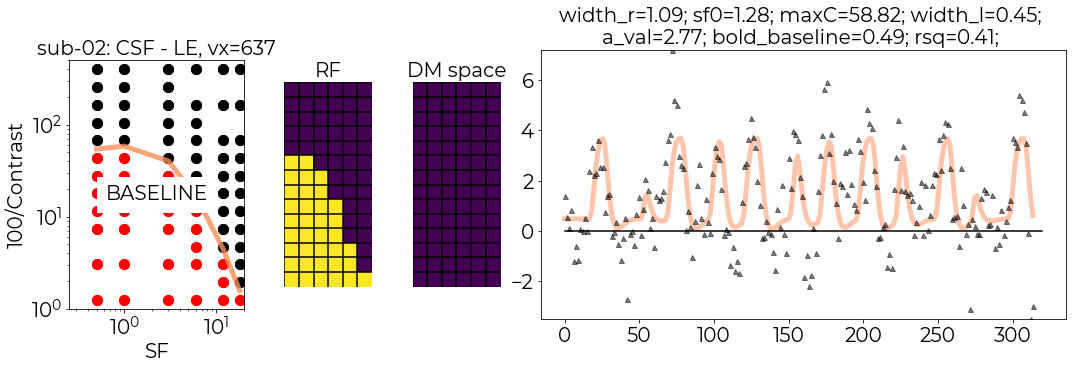

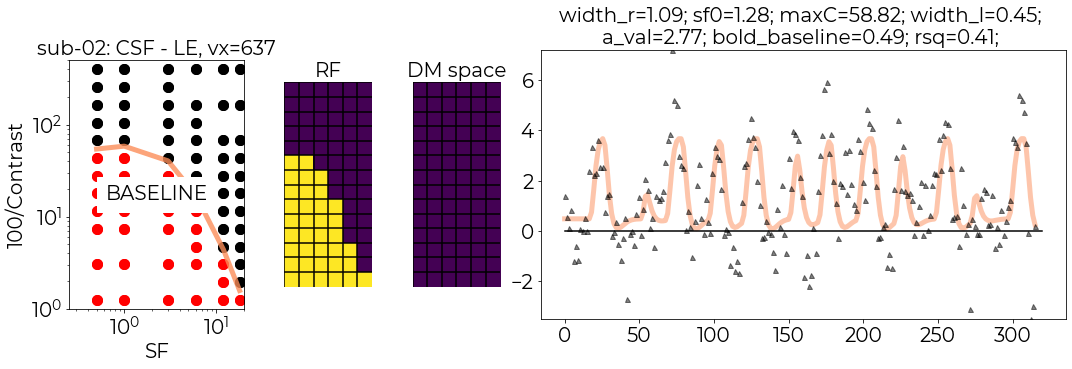

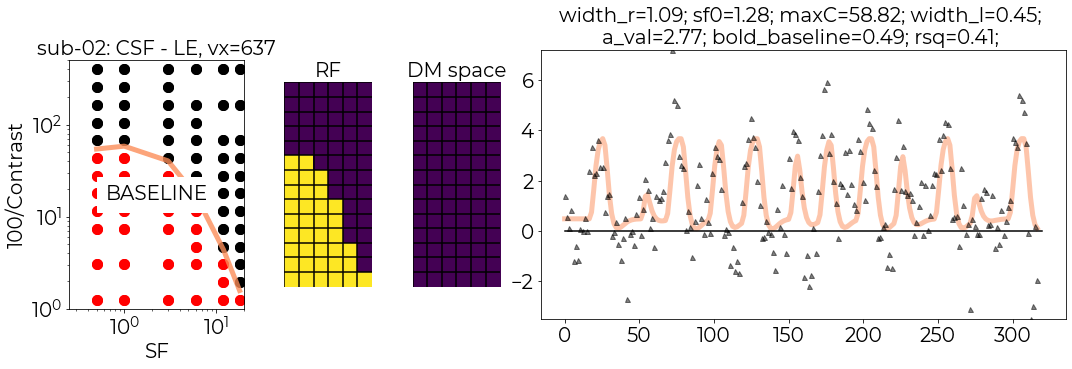

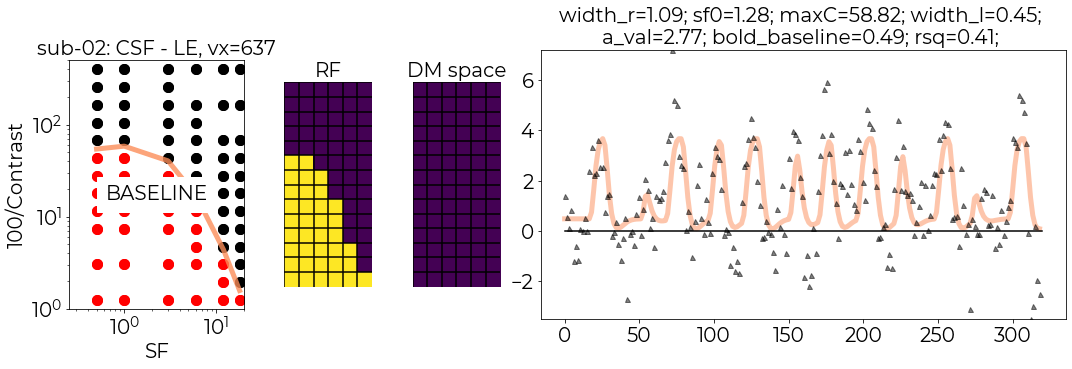

In [365]:
sub='sub-02'
eye = 'LE'
idx = np.where(G_plot['sub-02'].return_vx_mask({
    'CSF-LE-min-rsq':.4,
    'CSF-LE-bound-bold_baseline':[-.5,.5]}))[0][1]


save_name = f'./csf_tc_{sub}-{eye}-vx{idx}'
# if not os.path.exists(save_name):
#     os.mkdir(save_name)
i_0 = 200
i_m1 = 214
i_step = 1
i_fig = 0
for i in range(i_0,i_m1,i_step):
    fig = G_plot[sub].csf_tc_plotV3(eye, idx, i)

    # fig.savefig(f"{save_name}/file{i_fig:03}.png")
    # plt.close(fig)
    print(i_fig)
    i_fig += 1


In [371]:
def grate_texture(sf=1, con=1, n_pix=200):
    n_deg = 5
    x_grid,y_grid = np.meshgrid(np.linspace(-n_deg,n_deg,n_pix),np.linspace(-n_deg,n_deg,n_pix))
    ecc = np.sqrt(x_grid**2 + y_grid**2)
    grate = np.cos(x_grid*sf) * con
    grate[ecc>n_deg] = 0
    # plt.imshow(grate, vmin=-1, vmax=1)
    return grate

CSF_stim=amb_load_prfpy_stim('CSF')
def make_csf_img_graph(t_pt, CSF_stim):
    fig, ax = plt.subplots(1,3, gridspec_kw={'width_ratios': [2,2,1]})
    fig.set_size_inches(12,5)
    grate = grate_texture(sf=CSF_stim.SF_seq[t_pt], con=CSF_stim.CON_seq[t_pt]/100)
    ax[0].imshow(grate, vmin=-1, vmax=1, cmap='Greys')
    ax[0].axis('off')
    ax[0].set_title(f'SF={CSF_stim.SF_seq[t_pt]:.3f}, C={CSF_stim.CON_seq[t_pt]:.3f}')

    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    ax[1].scatter(CSF_stim.SF_seq[0:t_pt], 100/CSF_stim.CON_seq[0:t_pt], c='k', s=100)
    if sf_vect[t_pt]==0:
        ax[1].text(.5, .5, 'BASELINE',
                horizontalalignment='center',
                verticalalignment='top',
                backgroundcolor='1',
                transform=ax[1].transAxes)            
    else:        
        ax[1].scatter(CSF_stim.SF_seq[t_pt], 100/CSF_stim.CON_seq[t_pt], marker='*', c='g', s=500)

    ax[1].set_xlim(.25,20)
    ax[1].set_ylim(1,500)
    ax[1].set_aspect('equal')
    ax[1].set_xlabel('SF')
    ax[1].set_ylabel('100/Contrast')

    ax[2].imshow(CSF_stim.design_matrix[:,:,t_pt], vmin=0, vmax=1)
    ax[2].axis('off')
    ax[2].set_title('DM space')
    fig.set_tight_layout('tight')
    update_fig_fontsize(fig, 20)

    return fig


In [374]:

save_name = './csf_img_graph'
if not os.path.exists(save_name):
    os.mkdir(save_name)
i_0 = 0
i_m1 = sf_vect.shape[0]
i_step = 1
i_fig = 0
for i in range(i_0,i_m1,i_step):

    fig = make_csf_img_graph(i, CSF_stim)
    fig.savefig(f"{save_name}/file{i_fig:03}.png")
    plt.close(fig)
    print(i_fig)
    i_fig += 1

# ffmpeg_dir = "/home/**your_name**/.conda/envs/**env_name**/bin/ffmpeg"
ffmpeg_dir = '~/.conda/envs/dnsim_as/bin/ffmpeg'
# Select the directory with all of the images, and file name pattern
# >> -r 15 controls frame rate, can be faster or slower 
os.system(f"{ffmpeg_dir} -r 5 -i {save_name}/file%03d.png -codec mpeg4 -y {save_name}_movie.mp4")
os.system(f"rm -R {save_name}")

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213


ffmpeg version 4.4.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 9.4.0 (GCC)
  configuration: --prefix=/home/daghlian/.conda/envs/dnsim_as --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/x86_64-conda-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-demuxer=dash --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-vaapi --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-libvpx --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame --pkg-config=/home/conda/feedstock_root/build_artifacts/ffmpeg_1636205340875/_build_env/bin/pkg-config
  libavutil      56. 70.100 / 56. 70.100
  libavcodec     58.134.100 / 58.134.100
  libavformat    58. 76.100 / 58. 76.100
  libavdevice    58. 13.100 / 58. 13.100
  libavfilter     7.110.100 /  7.110.100
  libavresample   4.

0

In [376]:



# i_0 = 200
# i_m1 = 214#sf_vect.shape[0]
# i_step = 1
# i_fig = 0
# for i in range(i_0,i_m1,i_step):

#     fig = make_csf_img_graph(i, CSF_stim)
#     plt.figure()
#     i_fig += 1



In [ ]:

# save_name = './csf_img_graph'
# if not os.path.exists(save_name):
#     os.mkdir(save_name)
i_0 = 0
i_m1 = sf_vect.shape[0]
i_step = 1
i_fig = 0
for i in range(i_0,i_m1,i_step):
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    grate = grate_texture(sf=sf_vect[i], con=c_vect[i]/100)
    ax[0].imshow(grate, vmin=-1, vmax=1, cmap='Greys')
    ax[0].axis('off')

    ax[1].set_yscale('log')
    ax[1].set_xscale('log')

    ax[1].scatter(sf_vect[i_0:i], c_vect[i_0:i], c='k')
    ax[1].scatter(sf_vect[i], c_vect[i], c='r')
    ax[1].set_ylim(10**-1,10**2)
    ax[1].set_xlim(.1,20)
    ax[1].set_xlabel('SF')
    ax[1].set_ylabel('Contrast')
    fig.set_tight_layout('tight')
    update_fig_fontsize(fig, 20)

    fig.savefig(f"{save_name}/file{i_fig:03}.png")
    plt.close(fig)
    print(i_fig)
    i_fig += 1

# ffmpeg_dir = "/home/**your_name**/.conda/envs/**env_name**/bin/ffmpeg"
ffmpeg_dir = '~/.conda/envs/dnsim_as/bin/ffmpeg'
# Select the directory with all of the images, and file name pattern
# >> -r 15 controls frame rate, can be faster or slower 
os.system(f"{ffmpeg_dir} -r 4 -i {save_name}/file%03d.png -codec mpeg4 -y {save_name}_movie.mp4")
os.system(f"rm -R {save_name}")

In [19]:
sub = 'sub-02'
CSF_stim = amb_load_prfpy_stim('CSF')
# SFs = np.linspace(0.5,18,30)
# log_SFs = np.log10(SFs)
# S_curve = np.squeeze(get_csf_curves(
#     log_SFs=log_SFs,
#     width_r=2.5,
#     sf0=1.12,
#     maxC=68.97,
#     width_l=0.448))
eye='LE'
min_rsq = 0.1
vx_mask = G_plot[sub].return_vx_mask({f'CSF-{eye}-min-rsq':min_rsq})
ps_to_vary = ['width_r', 'sf0', 'maxC']
width_l = 0.448
# [1] Find the p_range, and weighted mean (used for ...)
p_range = {}
p_wmean = {}
for i in ps_to_vary:
    this_p = G_plot[sub].return_th_param('CSF', eye, i, vx_mask)
    q1 = np.percentile(this_p, 25)
    q2 = np.percentile(this_p, 75)    
    p_range[i] = np.linspace(q1,q2,5)

    p_wmean[i] = G_plot[sub].return_w_mean('CSF', eye, i, vx_mask)


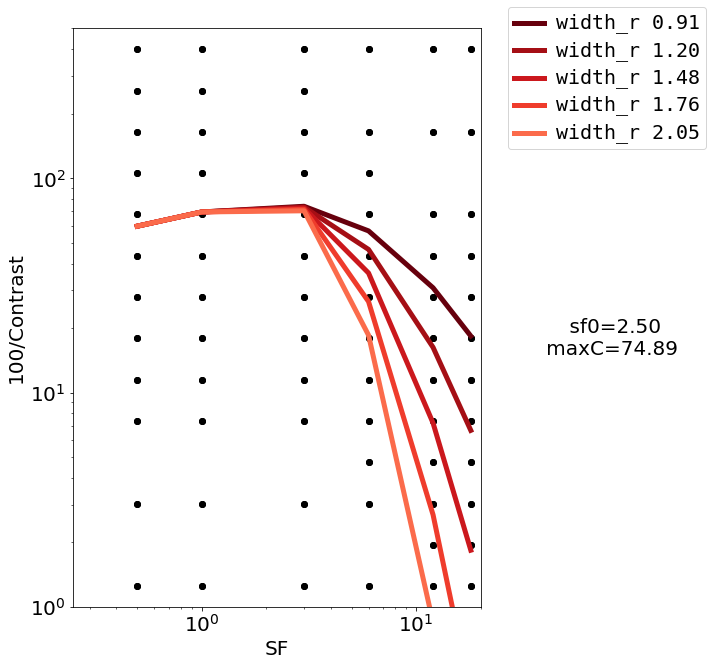

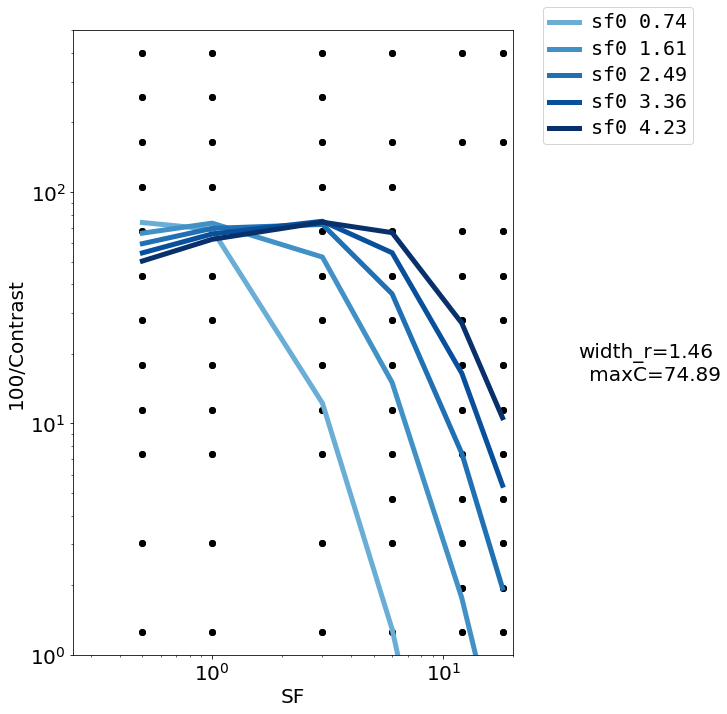

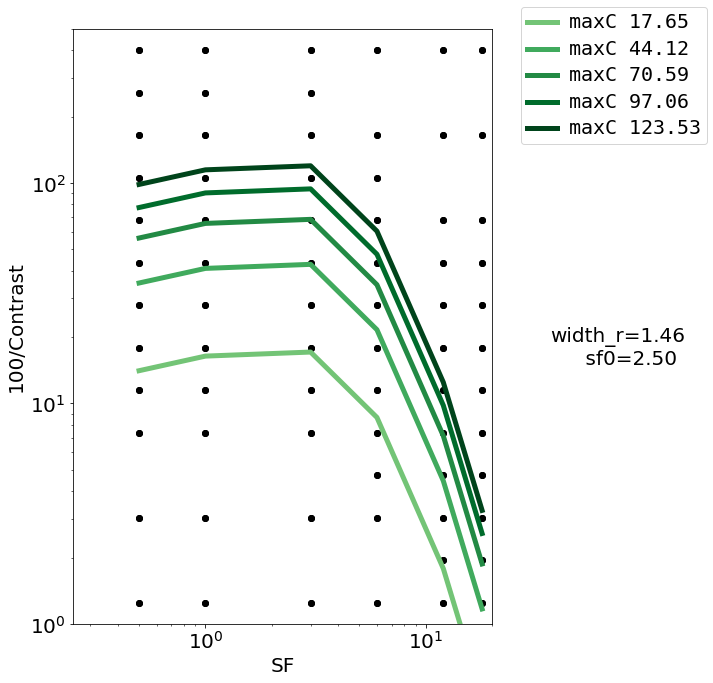

In [26]:
cmap_list = ['Reds_r', 'Blues', 'Greens']
for i_cmap,this_p in enumerate(ps_to_vary):
    fig, ax = plt.subplots(1)
    fig.set_size_inches(10,15)
    # Set up axes
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.scatter(CSF_stim.SF_seq, 100/CSF_stim.CON_seq, c='k')
    ax.set_xlabel('SF')
    ax.set_ylabel('100/Contrast')
    # ax[i].plot(SFs, S_curve, lw=5)
    y_lim = (1, 500)
    x_lim = (.25,20)
    ax.set_ylim(y_lim)
    ax.set_xlim(x_lim)
    ax.set_aspect('equal')

    # AX [1] Vary width_r:
    if '_r' in cmap_list[i_cmap]:
        col = plt.cm.__dict__[cmap_list[i_cmap]](np.linspace(0,.5,5))
    else:
        col = plt.cm.__dict__[cmap_list[i_cmap]](np.linspace(.5,1,5))
    for i,i_pval in enumerate(p_range[this_p]):
        if this_p=='width_r':
            this_width_r = i_pval
        else:
            this_width_r = p_wmean['width_r']
        if this_p=='sf0':
            this_sf0 = i_pval
        else:
            this_sf0 = p_wmean['sf0']

        if this_p=='maxC':
            this_maxC = i_pval
        else:
            this_maxC = p_wmean['maxC']
        
        S_curve = np.squeeze(get_csf_curves(
            log_SFs=CSF_stim.log_SFs,
            width_r=this_width_r,
            sf0=this_sf0,
            maxC=this_maxC,
            width_l=0.448))    
        ax.plot(CSF_stim.SFs, S_curve, label=f'{this_p} {i_pval:.2f}', lw=5, c=col[i])
    # ax[0].legend()
    param_text = ''
    for p4txt in ps_to_vary:
        if p4txt==this_p:
            continue
        param_text += f'{p4txt:>7}={p_wmean[p4txt]:.2f}\n'
    ax.legend(bbox_to_anchor=(1.05, 1.05), prop={'size':15,'family': 'monospace'})
    ax.text(1.3,.5, param_text,                     
            horizontalalignment='center',
            verticalalignment='top',
            backgroundcolor='1',
            transform=ax.transAxes) 

    fig.set_tight_layout('tight')
    update_fig_fontsize(fig, 20)
    fig.savefig(f'{this_p}.png')




In [383]:
min_rsq = 0.1
eye = 'LE'
vx_mask = G_plot[sub].return_vx_mask({'CSF-LE-min-rsq':min_rsq})
for i in G_plot[sub].p_labels['CSF'].keys():
    
    this_wp = G_plot[sub].return_w_mean('CSF', eye, i, vx_mask)
    print(f'{i} = {this_wp}')

width_r = 1.464769672327508
sf0 = 2.5004147060773163
maxC = 74.89459258016657
width_l = 0.44799999999999995
a_val = 2.563195423517712
bold_baseline = 0.6736544001335836
rsq = 0.24085419934673485


In [3]:
cmap_dict = {
    'width_r' : 'Reds_r',       
    'sf0' : 'Blues'     ,
    'maxC' : 'Greens',
    'pol' : None   ,   
    'ecc' : 'magma' ,    
    'rsq' : 'cool'   ,     
}
for sub in ['01', '02']:
    for eye in ['LE', 'RE']:
        for param in ['width_r', 'sf0', 'maxC', 'pol', 'ecc', 'rsq']:
            if (param=='pol') | (param=='ecc'):
                model = 'gauss'
                task = f'pRF{eye}'
            else:
                model = 'CSF'
                task = f'CSF{eye}'
            
            fview_cmd = f'python ../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py -s {sub} -t {task} --param {param}  --model {model} --scr_shot --cmap {cmap_dict[param]}'

            os.system(fview_cmd)
            input()
            


Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-01..


Traceback (most recent call last):
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 234, in <module>
    main(sys.argv[1:])
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 186, in main
    fv_cmap = mpl.cm.__dict__[fv_cmap_name]
KeyError: 'maxC'


Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-01..


Traceback (most recent call last):
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 234, in <module>
    main(sys.argv[1:])
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 186, in main
    fv_cmap = mpl.cm.__dict__[fv_cmap_name]
KeyError: 'maxC'


Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-01..
Making new surface files for sub-02..
Making new surface files for sub-02..
Making new surface files for sub-02..


Traceback (most recent call last):
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 234, in <module>
    main(sys.argv[1:])
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 186, in main
    fv_cmap = mpl.cm.__dict__[fv_cmap_name]
KeyError: 'maxC'


Making new surface files for sub-02..
Making new surface files for sub-02..
Making new surface files for sub-02..
Making new surface files for sub-02..
Making new surface files for sub-02..
Making new surface files for sub-02..


Traceback (most recent call last):
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 234, in <module>
    main(sys.argv[1:])
  File "/data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/code/amb_code/z_untracked/../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plot.py", line 186, in main
    fv_cmap = mpl.cm.__dict__[fv_cmap_name]
KeyError: 'maxC'


Making new surface files for sub-02..
Making new surface files for sub-02..
Making new surface files for sub-02..


In [14]:
for sub in ['01', '02']:
    for eye in ['LE', 'RE']:
        for param in ['width_r', 'sf0', 'maxC', 'pol', 'ecc', 'rsq']:
            if (param=='pol') | (param=='ecc'):
                model = 'gauss'
            else:
                model = 'CSF'
            
            fview_cmd = f'python ../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plotV2.py -s {sub} -e {eye} --param {param} --model {model} --scr_shot'
            # print(fview_cmd)
            os.system(fview_cmd)
            


File to be named: sub-01_width_r_LE_CSF
Overwriting: sub-01_width_r_LE_CSF for sub-01
saving lh & rh sub-01_width_r_LE_CSF in sub-01 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-01_width_r_LE_CSF:overlay_custom=0.00,103,0,12,0.33,157,13,20,0.67,193,21,27,1.00,227,47,39,1.33,245,84,60,1.67,251,124,92,2.00,252,159,129,2.33,252,195,172,2.67,254,226,213,3.00,255,245,240, rh.inflated:overlay=rh.sub-01_width_r_LE_CSF:overlay_custom=0.00,103,0,12,0.33,157,13,20,0.67,193,21,27,1.00,227,47,39,1.33,245,84,60,1.67,251,124,92,2.00,252,159,129,2.33,252,195,172,2.67,254,226,213,3.00,255,245,240, --camera Azimuth 90 Zoom 1.5 Elevation -35 Roll 0 --colorscale --ss /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/surf_shots/sub-01_width_r_LE_CSF
File to be named: sub-01_sf0_LE_CSF
Overwriting: sub-01_sf0_LE_CSF for sub-01
saving lh & rh sub-01_sf0_LE_CSF in sub-01 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-01_sf0_LE_CSF:overlay_custom=0.00,247,

In [30]:
for sub in ['01', '02']:
    for eye in ['LE', 'RE']:
        for param in ['sfmax']:
            model = 'CSF'
            
            fview_cmd = f'python ../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plotV2.py -s {sub} -e {eye} --param {param} --model {model} --scr_shot'
            # print(fview_cmd)
            os.system(fview_cmd)
            


File to be named: sub-01_sfmax_LE_CSF
Writing: sub-01_sfmax_LE_CSF for sub-01
saving lh & rh sub-01_sfmax_LE_CSF in sub-01 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-01_sfmax_LE_CSF:overlay_custom=0.00,68,1,84,13669939076787108990871949943579770779115805978770587640398804568633136644096.00,71,39,119,27339878153574217981743899887159541558231611957541175280797609137266273288192.00,62,73,137,41009817230361328579553894089729587879309510277474365443399407488692245233664.00,48,103,141,54679756307148435963487799774319083116463223915082350561595218274532546576384.00,37,130,142,68349695383935549775173882494869680521465306917340745768603004191544189124608.00,30,157,136,82019634460722657159107788179459175758619020554948730886798814977384490467328.00,53,183,120,95689573537509764543041693864048670995772734192556716004994625763224791810048.00,109,206,88,109359512614296871926975599548638166232926447830164701123190436549065093152768.00,181,221,43,12302945169108397931090950523322766147008

error: WARNING: 8 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/rh.sub-01_sfmax_LE_CSF...



File to be named: sub-01_sfmax_RE_CSF
Writing: sub-01_sfmax_RE_CSF for sub-01
saving lh & rh sub-01_sfmax_RE_CSF in sub-01 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-01_sfmax_RE_CSF:overlay_custom=0.00,68,1,84,133458692460233381529073942602942596413733367127238038237793498548444547327592610461455330732512405112618024801664868844306432.00,71,39,119,266917384920466763058147885205885192827466734254476076475586997096889094655185220922910661465024810225236049603329737688612864.00,62,73,137,400376077380700144587221827808827789241200101381714114713380495645333641982777831384365992197537215337854074404994606532919296.00,48,103,141,533834769840933526116295770411770385654933468508952152951173994193778189310370441845821322930049620450472099206659475377225728.00,37,130,142,667293462301166907645369713014712982068666835636190191188967492742222736637963052307276653662562025563090124008324344221532160.00,30,157,136,8007521547614002891744436556176555784824002027634282294267609912906672839

error: WARNING: 1 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/lh.sub-01_sfmax_RE_CSF...

error: WARNING: 1 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/rh.sub-01_sfmax_RE_CSF...



File to be named: sub-02_sfmax_LE_CSF
Writing: sub-02_sfmax_LE_CSF for sub-02
saving lh & rh sub-02_sfmax_LE_CSF in sub-02 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-02_sfmax_LE_CSF:overlay_custom=0.00,68,1,84,81564272172886129191786440659176313168063336032054763278786517130747345562625826360399365475161419877198339603727980798320114523001854423691075868390020156863657781466321581692175912714360128523309176853830278458434808852753665333657600.00,71,39,119,163128544345772258383572881318352626336126672064109526557573034261494691125251652720798730950322839754396679207455961596640229046003708847382151736780040313727315562932643163384351825428720257046618353707660556916869617705507330667315200.00,62,73,137,244692816518658376279303487144658951707754639277652836430943903985931937954269755630422774980690260008099334830263954511368881575869576958580040141656496680084760990451180319353343372212215903279399240590676724480274988642922874538033152.00,48,103,141,32625708869154451676714

error: WARNING: 8 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/lh.sub-02_sfmax_LE_CSF...

error: WARNING: 12 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/rh.sub-02_sfmax_LE_CSF...



File to be named: sub-02_sfmax_RE_CSF
Writing: sub-02_sfmax_RE_CSF for sub-02
saving lh & rh sub-02_sfmax_RE_CSF in sub-02 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-02_sfmax_RE_CSF:overlay_custom=0.00,68,1,84,1155453122860442898560712704.00,71,39,119,2310906245720885797121425408.00,62,73,137,3466359368581328833121091584.00,48,103,141,4621812491441771594242850816.00,37,130,142,5777265614302214905120423936.00,30,157,136,6932718737162657666242183168.00,53,183,120,8088171860023100427363942400.00,109,206,88,9243624982883543188485701632.00,181,221,43,10399078105743985949607460864.00,253,231,36, rh.inflated:overlay=rh.sub-02_sfmax_RE_CSF:overlay_custom=0.00,68,1,84,1155453122860442898560712704.00,71,39,119,2310906245720885797121425408.00,62,73,137,3466359368581328833121091584.00,48,103,141,4621812491441771594242850816.00,37,130,142,5777265614302214905120423936.00,30,157,136,6932718737162657666242183168.00,53,183,120,8088171860023100427363942400.00,109,206,88,9243624982883543188

In [84]:
for sub in ['01', '02']:
    for eye in ['LE', 'RE']:
        for param in ['sfmax']:
            model = 'CSF'            
            fview_cmd = f'python ../amb_scripts/data_prf_fits_scripts/freesurfer_pol_plotV2.py -s {sub} -e {eye} --param {param} --model {model} --scr_shot'

            os.system(fview_cmd)
            a = input()
            if a=='q':
                sys.exit()


File to be named: sub-01_sfmax_LE_CSF
Overwriting: sub-01_sfmax_LE_CSF for sub-01
saving lh & rh sub-01_sfmax_LE_CSF in sub-01 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-01_sfmax_LE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, rh.inflated:overlay=rh.sub-01_sfmax_LE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, --camera Azimuth 90 Zoom 1.5 Elevation -35 Roll 0 --colorscale --ss /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/surf_shots/sub-01_sfmax_LE_CSF
NaN found at voxel (6549, 0, 0, 0)
NaN found at voxel (121249, 0, 0, 0)
NaN found at voxel (77674, 0, 0, 0)
NaN found at voxel (77674, 0, 0, 0)



error: WARNING: 11 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/rh.sub-01_sfmax_LE_CSF...



File to be named: sub-01_sfmax_RE_CSF
Overwriting: sub-01_sfmax_RE_CSF for sub-01
saving lh & rh sub-01_sfmax_RE_CSF in sub-01 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-01_sfmax_RE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, rh.inflated:overlay=rh.sub-01_sfmax_RE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, --camera Azimuth 90 Zoom 1.5 Elevation -35 Roll 0 --colorscale --ss /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/surf_shots/sub-01_sfmax_RE_CSF
NaN found at voxel (4943, 0, 0, 0)
NaN found at voxel (4943, 0, 0, 0)


error: WARNING: 3 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/lh.sub-01_sfmax_RE_CSF...

error: WARNING: 2 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-01/surf/rh.sub-01_sfmax_RE_CSF...



File to be named: sub-02_sfmax_LE_CSF
Overwriting: sub-02_sfmax_LE_CSF for sub-02
saving lh & rh sub-02_sfmax_LE_CSF in sub-02 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-02_sfmax_LE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, rh.inflated:overlay=rh.sub-02_sfmax_LE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, --camera Azimuth 90 Zoom 1.5 Elevation -20 Roll 0 --colorscale --ss /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/surf_shots/sub-02_sfmax_LE_CSF
NaN found at voxel (398, 0, 0, 0)
NaN found at voxel (398, 0, 0, 0)


error: WARNING: 14 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/lh.sub-02_sfmax_LE_CSF...

error: WARNING: 17 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/rh.sub-02_sfmax_LE_CSF...



File to be named: sub-02_sfmax_RE_CSF
Overwriting: sub-02_sfmax_RE_CSF for sub-02
saving lh & rh sub-02_sfmax_RE_CSF in sub-02 freesurfer folder
freeview -f lh.inflated:overlay=lh.sub-02_sfmax_RE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, rh.inflated:overlay=rh.sub-02_sfmax_RE_CSF:overlay_custom=0.00,247,251,255,2.22,225,236,247,4.44,203,222,240,6.67,171,207,229,8.89,130,186,219,11.11,88,161,206,13.33,55,135,192,15.56,26,105,174,17.78,8,76,150,20.00,8,48,107, --camera Azimuth 90 Zoom 1.5 Elevation -20 Roll 0 --colorscale --ss /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/surf_shots/sub-02_sfmax_RE_CSF
NaN found at voxel (64389, 0, 0, 0)
NaN found at voxel (64389, 0, 0, 0)


error: WARNING: 2 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/lh.sub-02_sfmax_RE_CSF...

error: WARNING: 1 NaNs found in volume /data1/projects/dumoulinlab/Lab_members/Marcus/projects/amblyopia_emc/derivatives/freesurfer/sub-02/surf/rh.sub-02_sfmax_RE_CSF...



In [65]:
prf_obj = Prf1T1M('sub-01', 'LE', 'CSF')

In [77]:
np.log10(-1)

nan

In [67]:
prf_obj.pd_params['sf0']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
314531    0.0
314532    0.0
314533    0.0
314534    0.0
314535    0.0
Name: sf0, Length: 314536, dtype: float64

In [85]:
roi_fit = 'all'
fit_stage = 'iter'
G_plot = {}
G_plot['sub-01'] = AmbPlotter('sub-01', roi_fit=roi_fit, fit_stage=fit_stage)
G_plot['sub-02'] = AmbPlotter('sub-02', roi_fit=roi_fit, fit_stage=fit_stage)

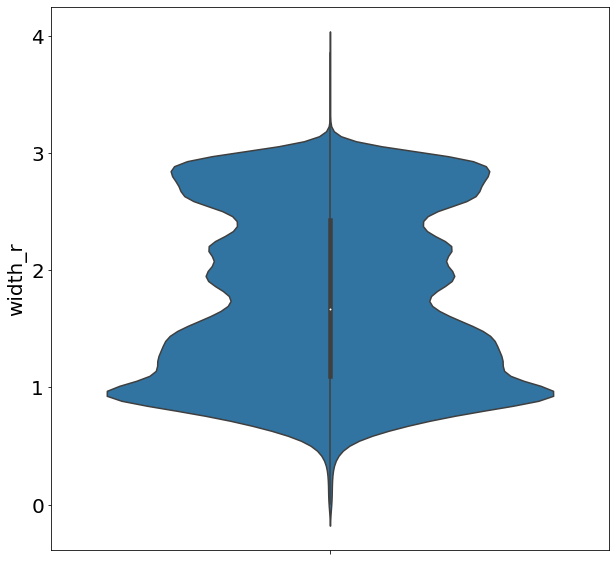

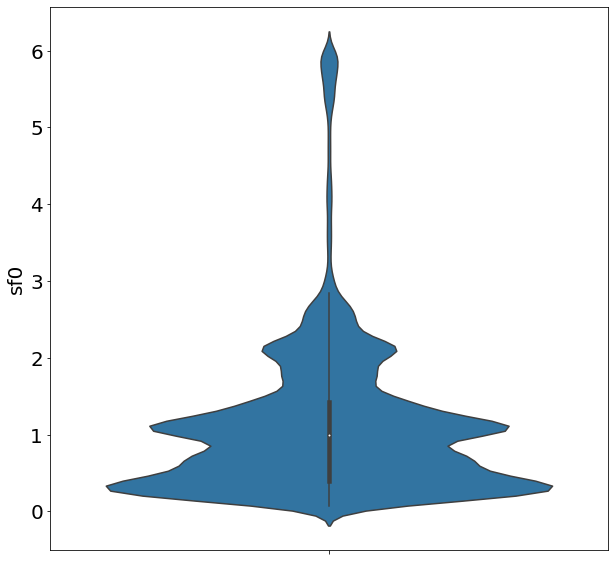

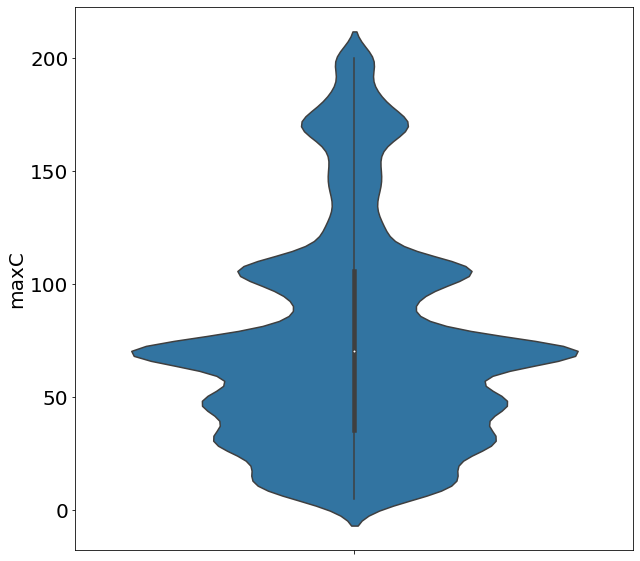

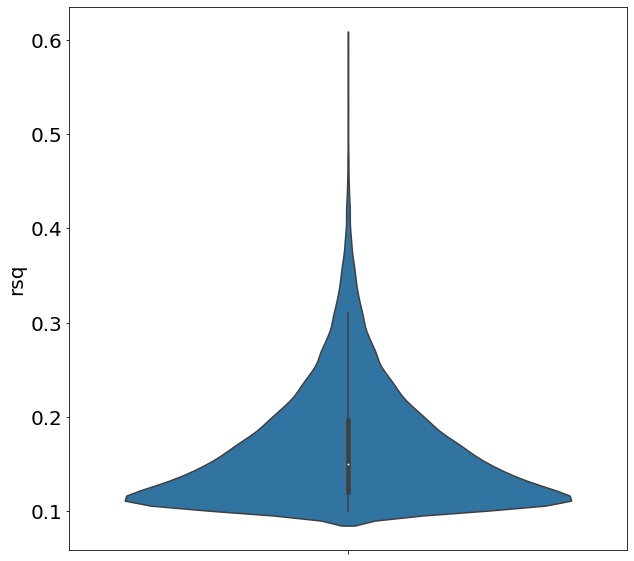

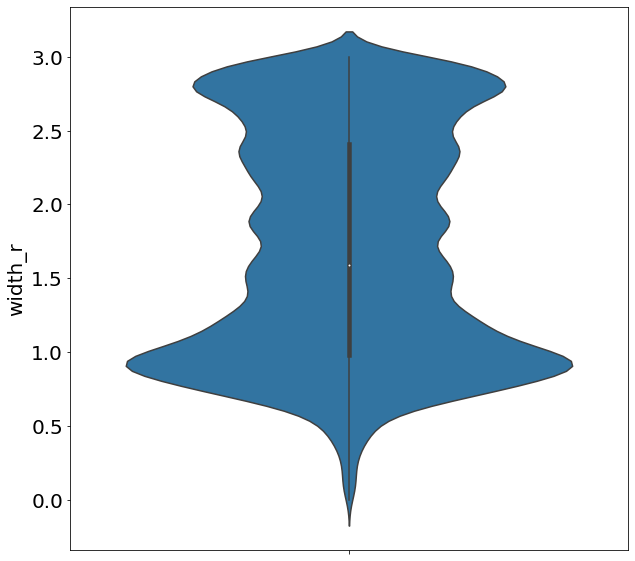

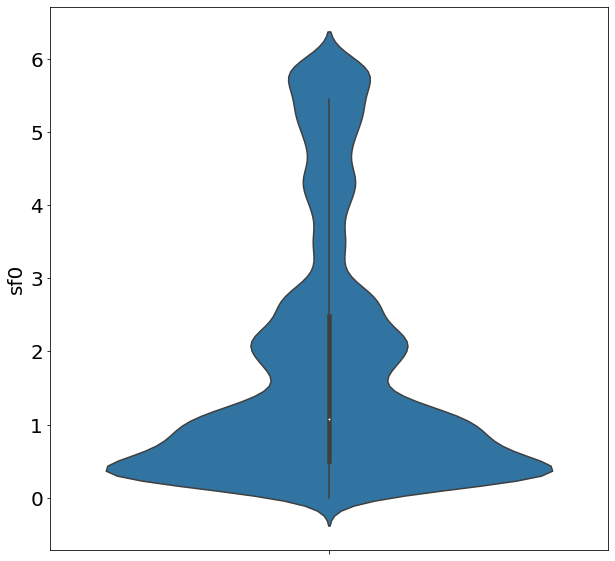

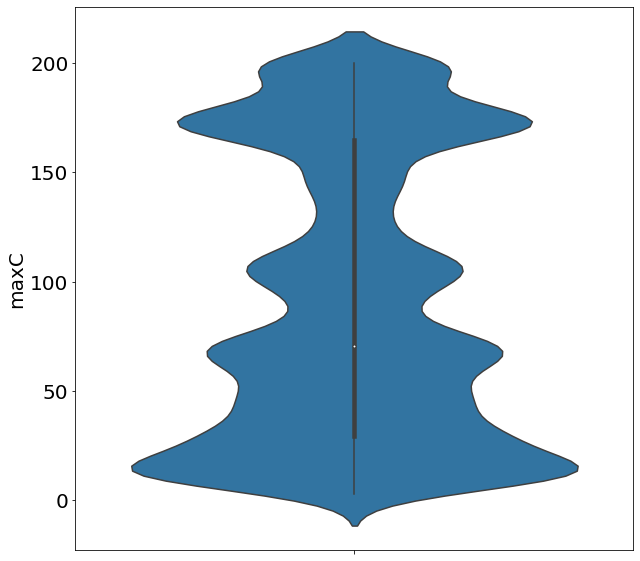

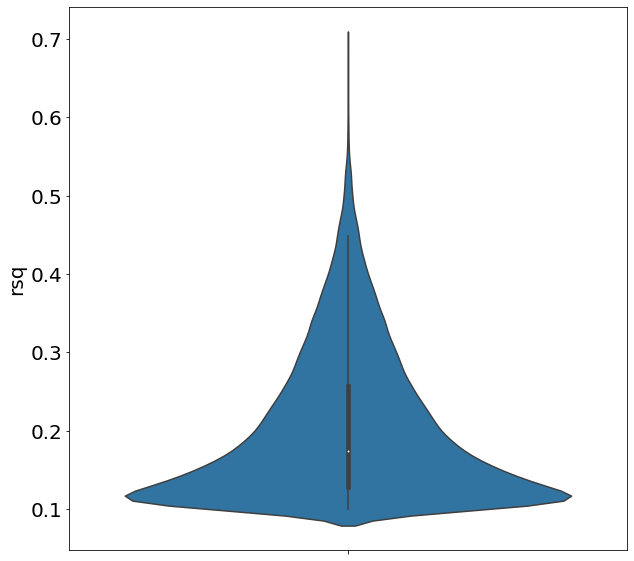

In [101]:
# Histograms LE vs RE
import seaborn as sns
import pandas as pd
model = 'CSF'
min_rsq = 0.1
for sub in ['sub-01', 'sub-02']:
    for param in ['width_r', 'sf0', 'maxC', 'rsq',]:

        fig, ax = plt.subplots(1)
        fig.set_size_inches(10,10)
        this_param_dict = {}        
        this_param_dict[param] = []
        this_param_dict['eye'] = []
        for eye in ['LE', 'RE']:
            vx_mask = G_plot[sub].return_vx_mask(th_dict={f'{model}-{eye}-min-rsq': min_rsq})                
            this_param_dict[param].append(G_plot[sub].return_th_param(model, eye, param, vx_mask).to_numpy())                
            this_param_dict['eye'].append([eye]*len(G_plot[sub].return_th_param(model, eye, param, vx_mask).to_numpy()))
        for key in this_param_dict.keys():
            this_param_dict[key] = np.concatenate(this_param_dict[key])
        this_param_pd = pd.DataFrame(this_param_dict)
        sns.violinplot(data=this_param_pd,y=param,hue='eye',split=True)# color=G_plot[sub].plot_cols[eye], facealpha=.5)
        # sns.boxplot(this_param)
        # G_plot[sub].hist_generic(axs=ax, vx_mask=vx_mask, param=f'{model}-{eye}-{param}', title=sub,)

        # ax.plot((0,1), (0,1), 'k')
        update_fig_fontsize(fig, 20)        
    

ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping threshold
ecc not a possible parameter for CSF
skipping th

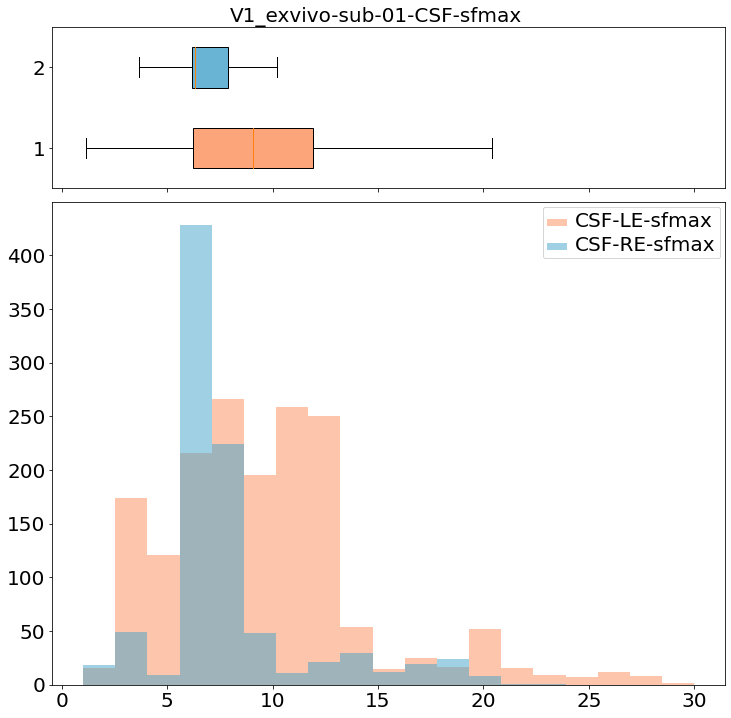

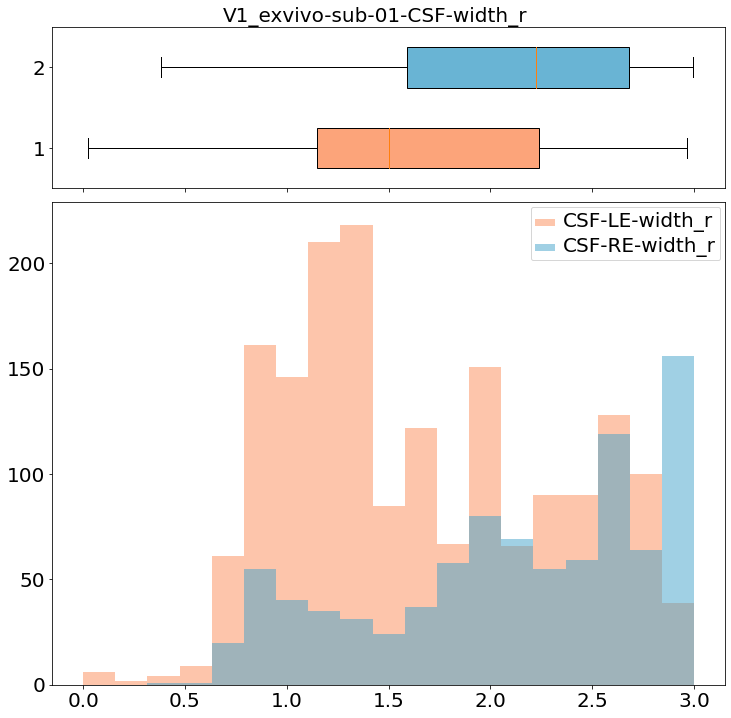

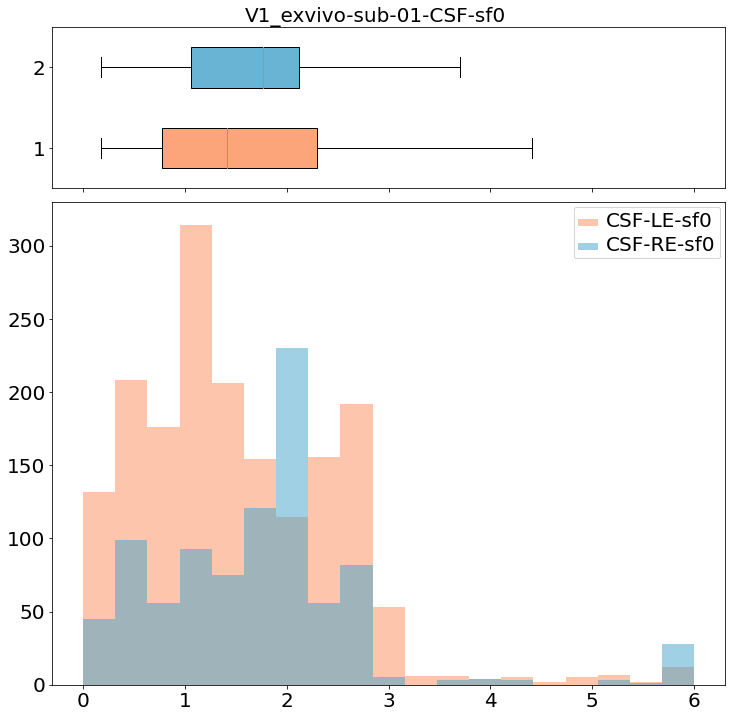

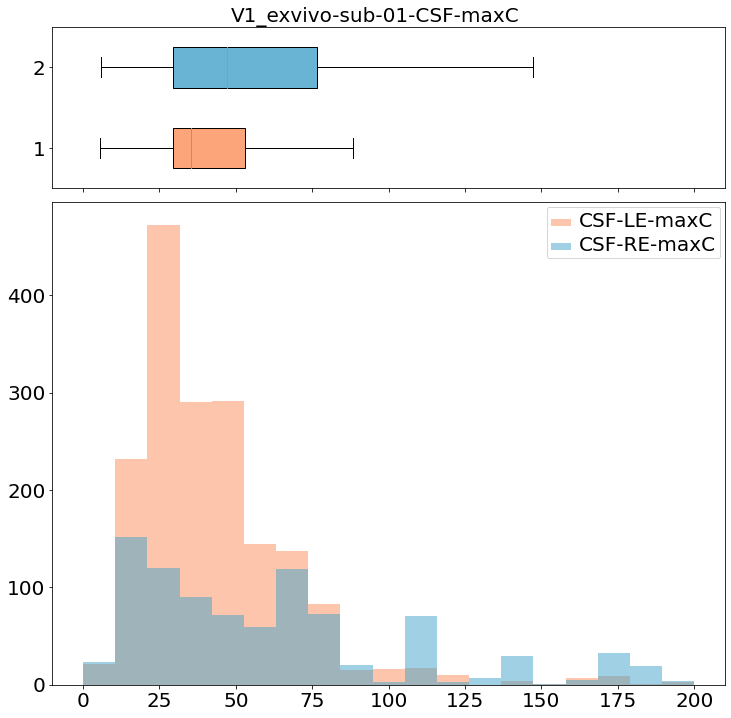

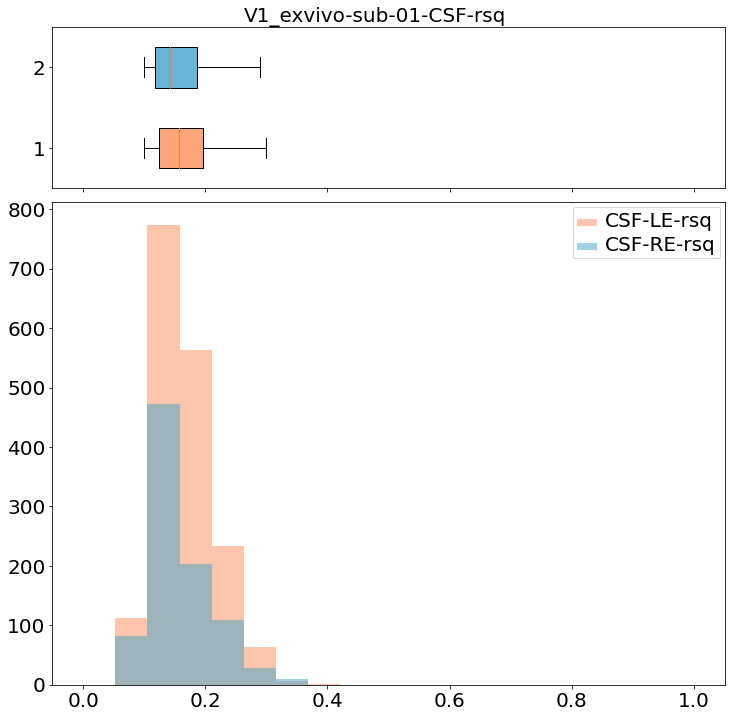

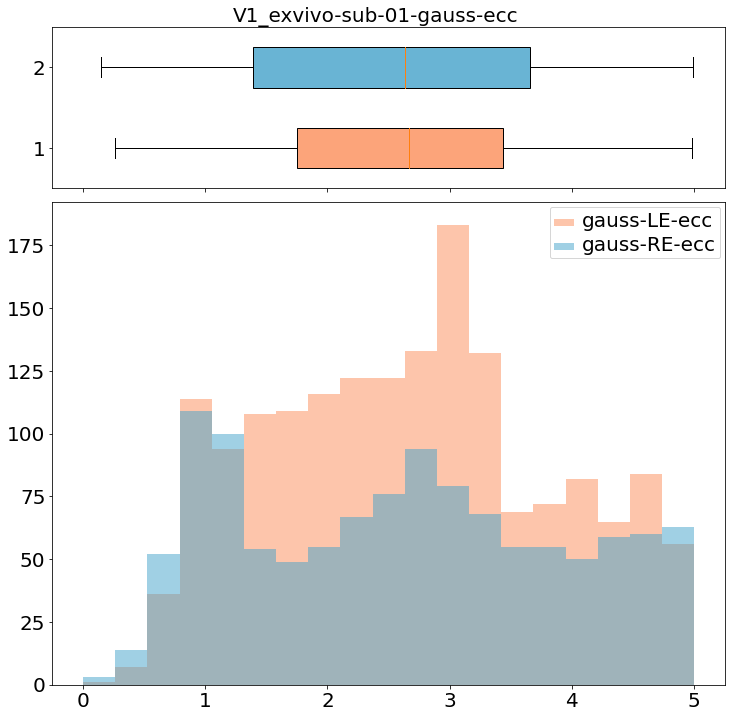

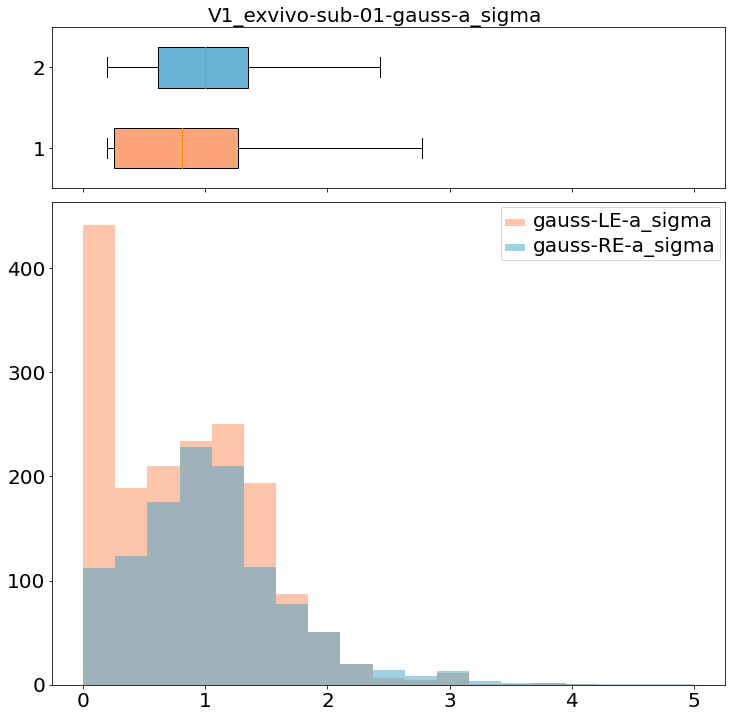

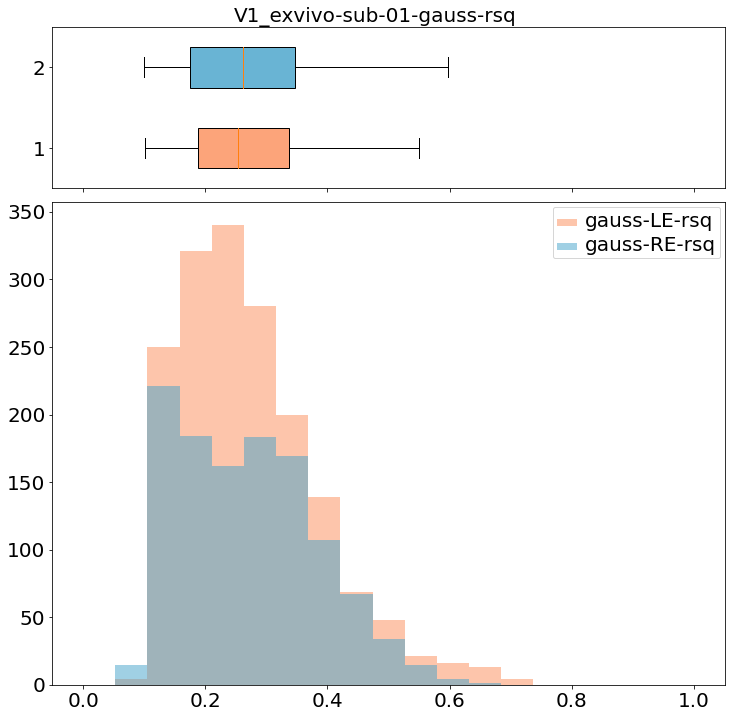

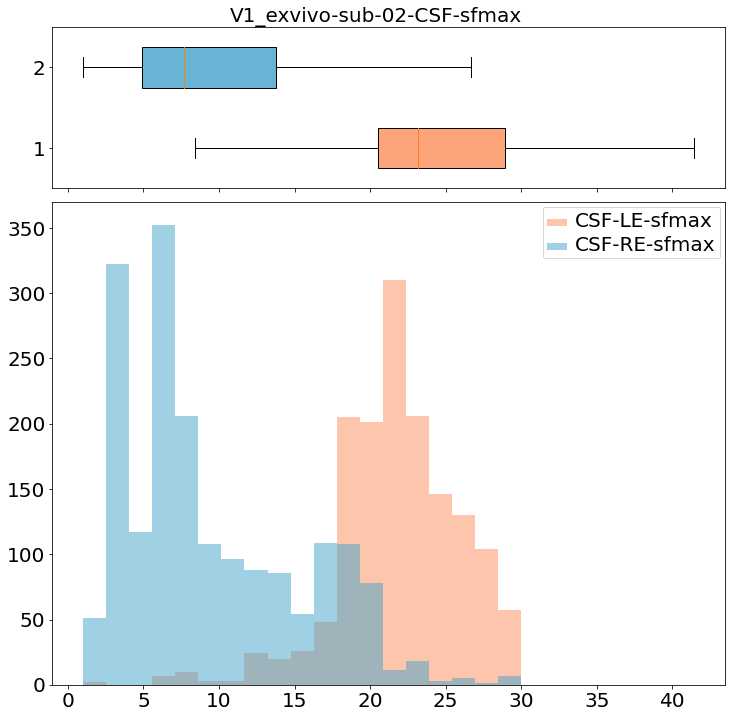

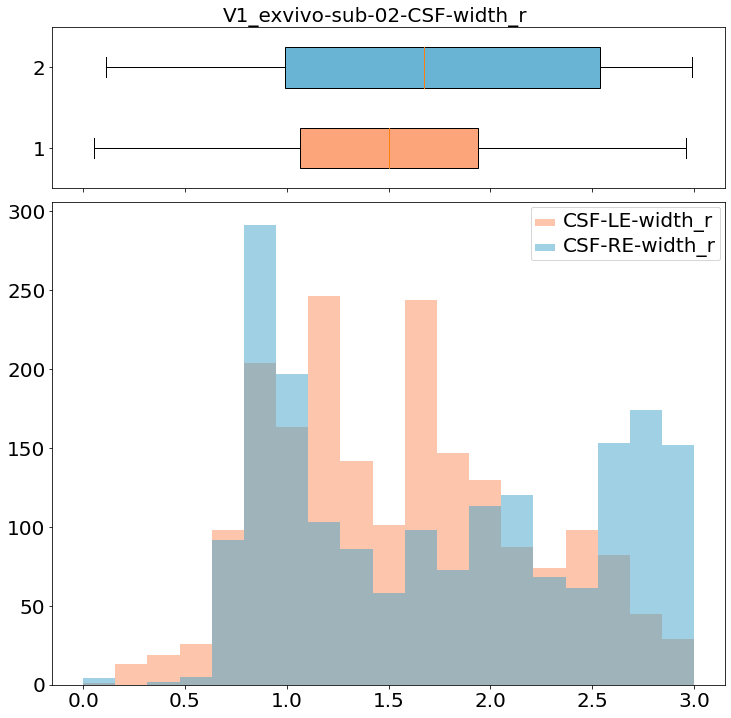

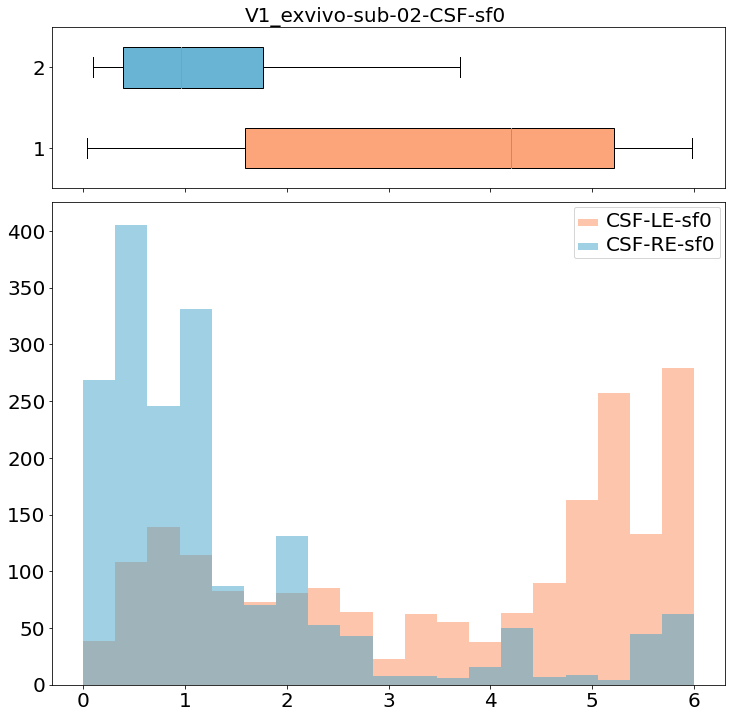

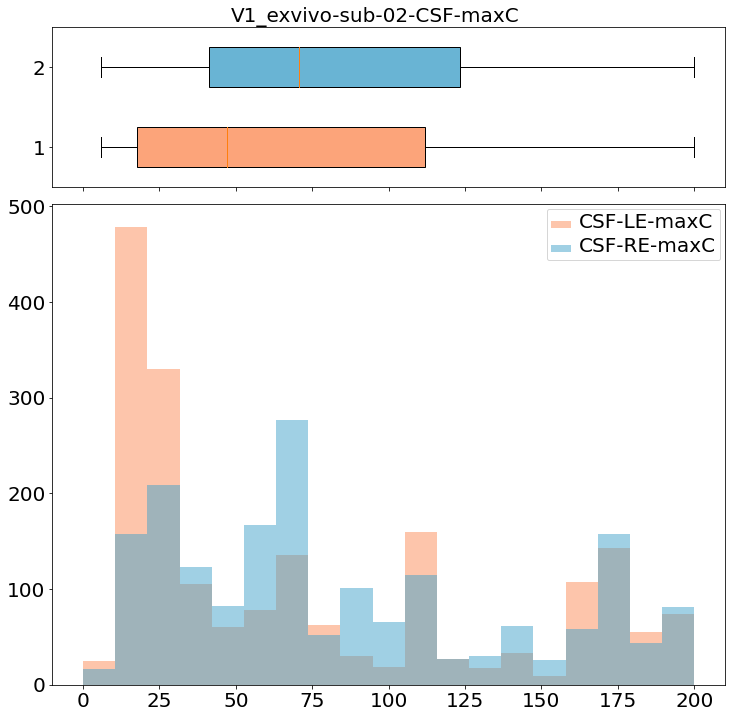

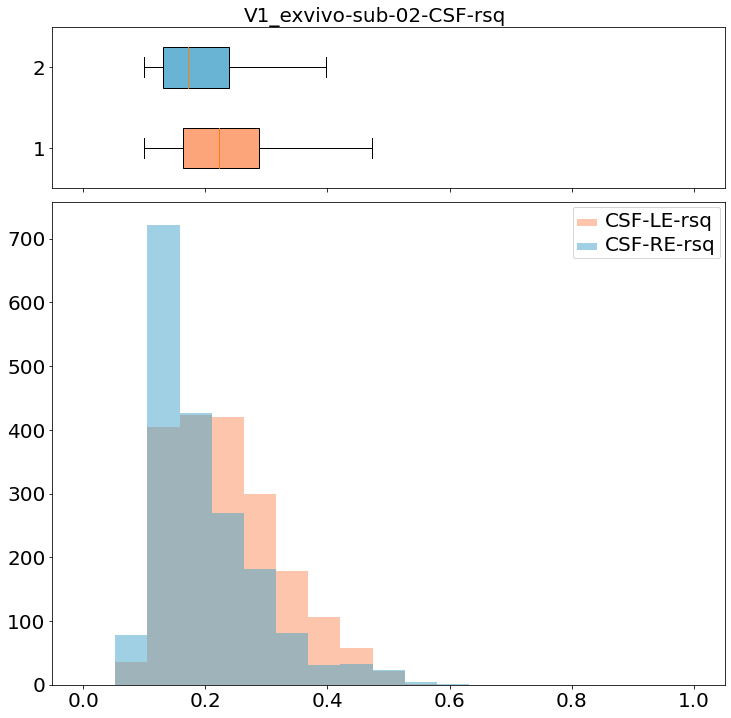

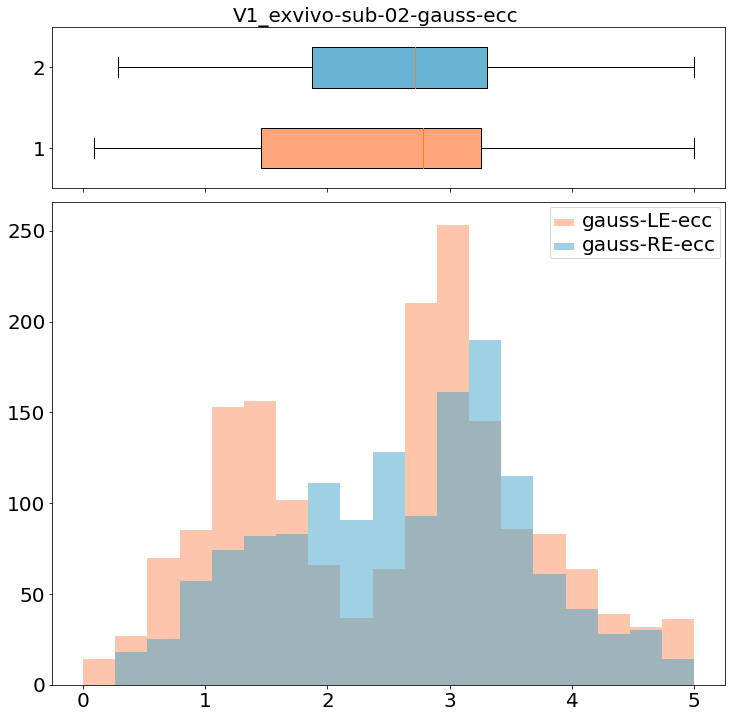

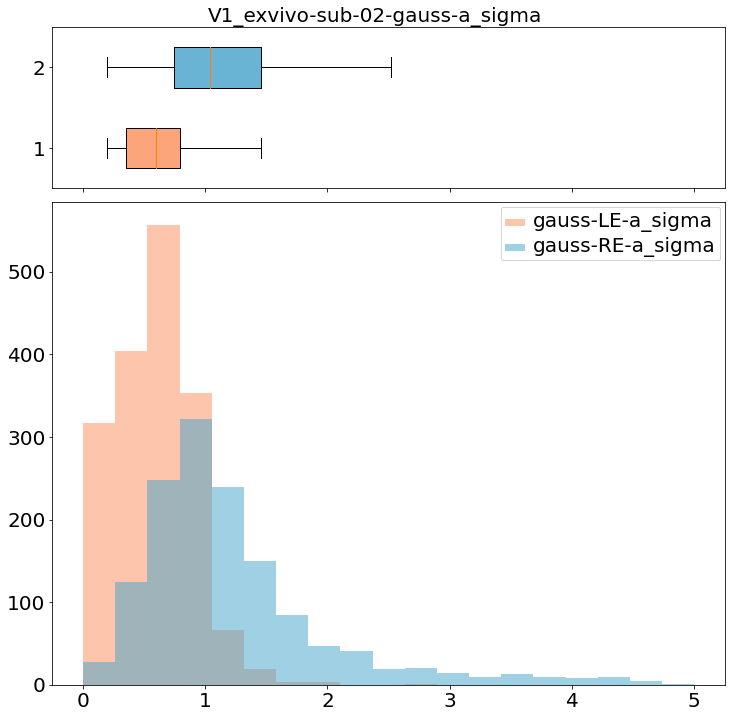

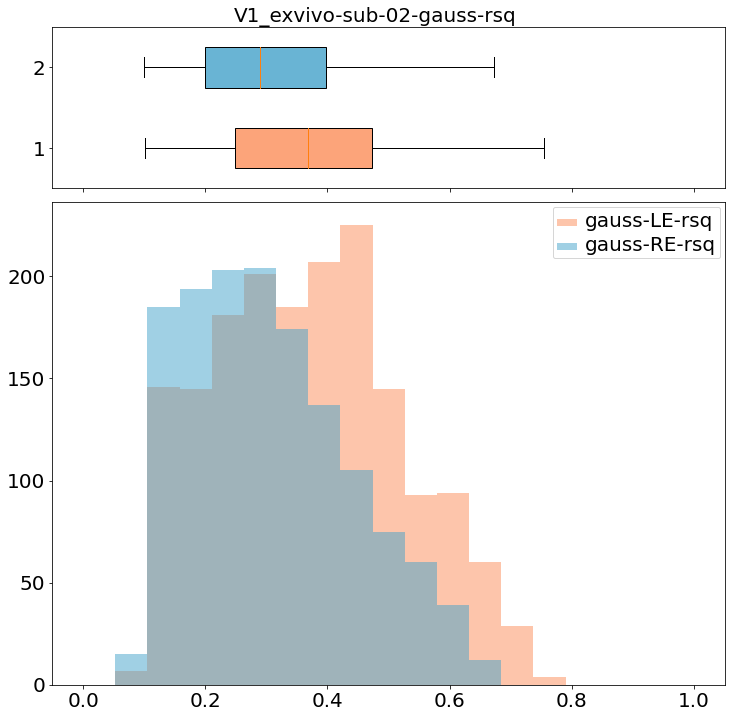

In [170]:
# Histograms LE vs RE
plot_cols = get_plot_cols()
min_rsq = 0.1
max_ecc = 5
roi = 'V1_exvivo'

model_list = ['CSF', 'gauss']

m_param_list = {
    'CSF' : ['sfmax', 'width_r', 'sf0', 'maxC', 'rsq'],
    'gauss' : ['ecc', 'a_sigma', 'rsq'],
}

n_bins = 20
m_param_bins = {
    'sfmax' : np.linspace(1,30,n_bins),
    'width_r' : np.linspace(0,3,n_bins),
    'sf0' : np.linspace(0,6,n_bins),
    'maxC' : np.linspace(0,200,n_bins),
    'rsq' : np.linspace(0,1,n_bins),
    'ecc' : np.linspace(0,5,n_bins),
    'a_sigma' : np.linspace(0,5,n_bins),

}

for sub in ['sub-01', 'sub-02']:
    for model in model_list:
        for param in m_param_list[model]:
            fig,(ax_box,ax_hist)=plt.subplots(nrows=2,sharex=True, gridspec_kw={'height_ratios':(.25,.75)},figsize=(10,10)) 
            roi_mask = amb_load_roi(sub, roi)
            this_p = []
            for eye in ['LE', 'RE']:
                vx_mask = G_plot[sub].return_vx_mask(th_dict={f'{model}-{eye}-min-rsq': min_rsq,f'{model}-{eye}-max-ecc': max_ecc, 'roi':roi_mask})                
                this_p.append(G_plot[sub].return_th_param(model, eye, param, vx_mask))
                G_plot[sub].hist_generic(axs=ax_hist, vx_mask=vx_mask, param=f'{model}-{eye}-{param}', bins=m_param_bins[param])
            
            bplot = ax_box.boxplot(this_p, showfliers=False, vert=False, widths=.5, patch_artist=True)
            bplot_cols = [plot_cols['LE'], plot_cols['RE']]
            for patch, color in zip(bplot['boxes'], bplot_cols):
                patch.set_facecolor(color)        

            # ax_box.set_xlim(0,20)
            # # ax.plot((0,1), (0,1), 'k')
            fig.suptitle(f"{roi}-{sub}-{model}-{param}")
            fig.tight_layout()
            update_fig_fontsize(fig, 20)
            fig.savefig(f'{roi}-{sub}-{model}-{param}.png')

        

In [158]:
type(None)

NoneType

In [154]:
a = np.where(G_plot['sub-01'].return_vx_mask({'CSF-LE-min-rsq':.1, 'CSF-LE-min-sfmax':99999999}))[0]

np.where(G_plot['sub-01'].pd_params['CSF']['LE']['sfmax']==np.inf)

(array([152448, 279862]),)